In [29]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [30]:
df = web.DataReader('HDFCBANK.NS', data_source='yahoo', start='2012-01-01', end='2021-02-17')
# df

In [31]:
df.shape


(2250, 6)

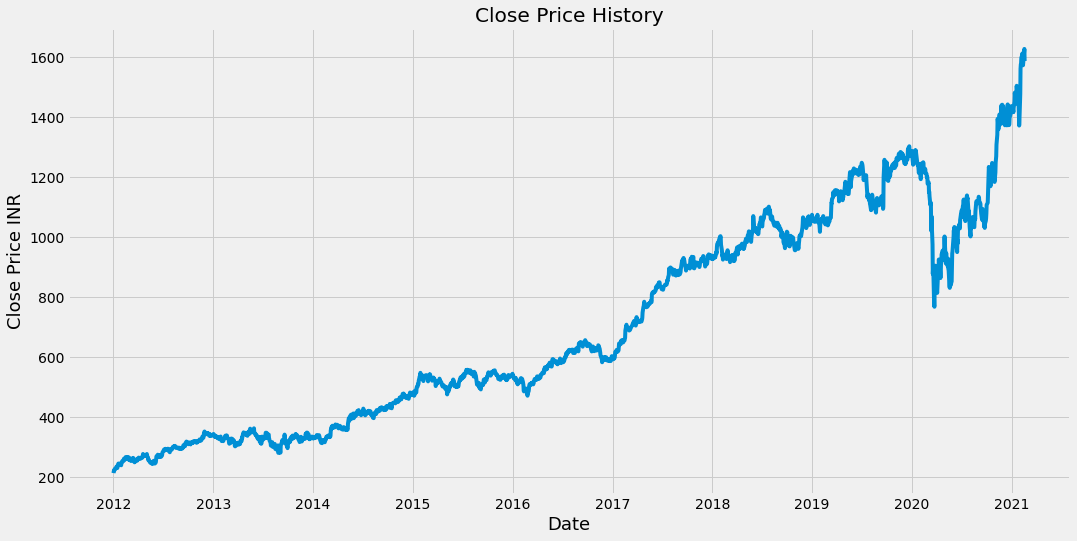

In [32]:
#visulaise the closing price
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

In [33]:
#Create a new dataframe with only close column
data = df.filter(['Close'])
dataset = data.values #converting to numpy array
#get the no of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1800

In [34]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.00435174],
       [0.00582002],
       ...,
       [0.99288857],
       [1.        ],
       [0.97158979]])

In [35]:
#Create the training dataset
#Create the scaled training dataset

train_data = scaled_data[0: training_data_len, :]
#Split the data into X_train and Y_train data sets

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60 : i, 0 ])
    y_train.append(train_data[i, 0])
#     if i<= 60:
#         print(x_train)
#         print(y_train)
#         print()

In [36]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1740, 60)

In [37]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #(1345, 60, 1)
x_train.shape

(1740, 60, 1)

In [38]:
#Build the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1))) #(60, 1)

model.add(LSTM(50, return_sequences=False, ))
model.add(Dense(25))
model.add(Dense(1))

In [39]:
#Compile the model

model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
#train the model

model.fit(x_train, y_train, batch_size=1, epochs=1)

1740/1740 [==============================] - 45s 24ms/step - loss: 7.1325e-04


In [41]:
#Create the testing data set

#Create a new array containing scaled values from index 1345 to end

test_data = scaled_data[training_data_len - 60 : , :]

#create the datasets x_test and y_test

x_test = []
y_test = dataset[training_data_len: , :] #this will contain the actual values

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60: i, 0])

In [42]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [43]:
#Reshape the datra
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [44]:
#get the models predicted price values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #we want predictions to contain the same values as y_test dataset



In [45]:
#Get the root mean squared error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

35.23015177408854

<ipython-input-46-e1db9ab83fe0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


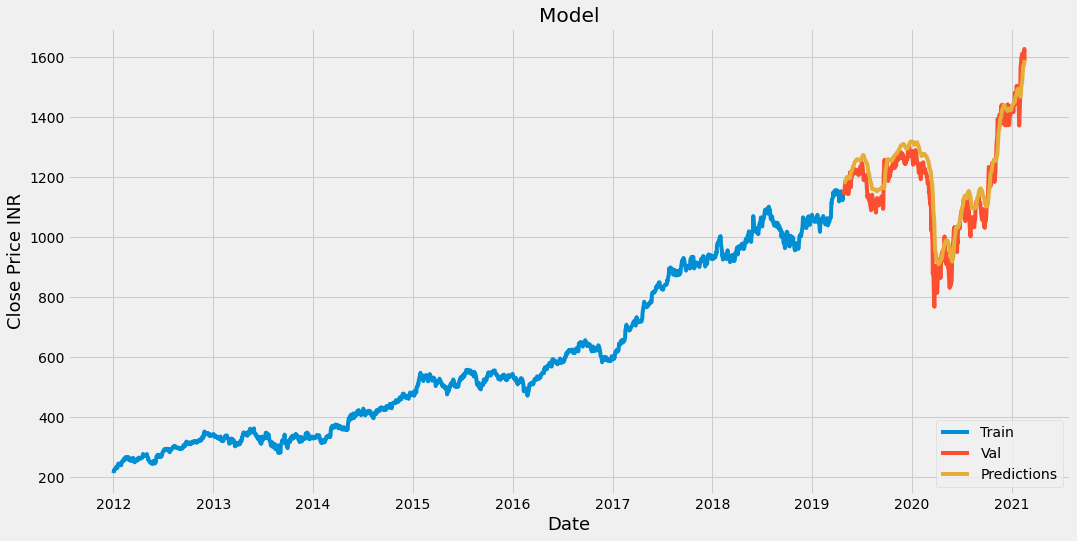

In [46]:
#Plot the data
train = data[0: training_data_len]
valid = data[training_data_len: ]
valid['Predictions'] = predictions

#Visulaize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [47]:
#Show the valid and predicted prices

valid

,Close,Predictions
Date,,
2019-04-26,1140.474976,1182.144287
2019-04-30,1158.724976,1181.876099
2019-05-02,1177.900024,1183.282104
2019-05-03,1183.974976,1186.885376
2019-05-06,1164.224976,1191.855957
...,...,...
2021-02-11,1572.349976,1560.916870
2021-02-12,1581.949951,1569.244629
2021-02-15,1616.599976,1575.689453


In [48]:
#try and predict closing price at dec 18 2019
quote = web.DataReader('HINDUNILVR.NS', data_source='yahoo', start='2012-01-01', end='2019-12-17')
#create new dataframe

new_df = quote.filter(['Close'])

#get last 60day closing price values and convert the dataframe to an array
last_60_days = new_df[-60: ].values

#scale the data
last_60_days_scaled = scaler.transform(last_60_days)

x_test = []
x_test.append(last_60_days_scaled)

#convert x_test to numpy array
x_test = np.array(x_test)

#reshape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#get the predicted scaled price
pred_price = model.predict(x_test)

#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[1948.1978]]


In [49]:
quote2 = web.DataReader('HINDUNILVR.NS', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(quote2['Close'])

Date
2019-12-18    1928.550049
Name: Close, dtype: float64


In [4]:
# quote5 = web.DataReader('ITC.NS', data_source='yahoo', start='2022-01-10', end='2022-04-10')
# #create new dataframe

# new_df = quote5.filter(['Close'])

# #get last 60day closing price values and convert the dataframe to an array
# last_60_days = new_df[-60: ].values

# #scale the data
# last_60_days_scaled = scaler.transform(last_60_days)

# x_test = []
# x_test.append(last_60_days_scaled)

# #convert x_test to numpy array
# x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# # x_test
# temp_input=list(x_test)
# temp_input=temp_input[0].tolist()
# temp_input = temp_input[0].values
# tenp_input

In [5]:
# from numpy import array

# lst_output=[]
# n_steps=60
# i=0
# while(i<30):
    
#     if(len(temp_input)>60):
#         #print(temp_input)
#         x_test=np.array(temp_input[1:])
# #         print("{} day input {}".format(i,x_input))
#         x_test=x_test.reshape(1,-1)
#         x_test = x_test.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_test, verbose=0)
# #         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_test = x_test.reshape((1, n_steps,1))
#         yhat = model.predict(x_test, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1